## 초기 데이터
- GDP : 미국, 영국, 유로존, 일본, 한국 (중국은 데이터가 상당히 부족해 제거)
- 국채금리 : 독일, 미국, 일본, 중국, 프랑스, 한국 각 1, 2, 3년 데이터
- 소비자 물가 지수 : 미국, 영국, 유로존, 중국, 한국(일본은 데이터가 상당히 부족해 제거)
- 소비자 신뢰 지수 : 미국, 영국, 유로존, 일본, 한국(중국은 데이터가 상당히 부족해 제거)
- 실업률 : 미국, 영국, 유로존, 일본, 한국(중국은 데이터가 상당히 부족해 제거)
- 환율 : CNY/KRW, EUR/KRW, GBP/KRW, JPY/KRW, USD/CNY, USD/EUR, USD/GBP, USD/JPY, USD/KRW
- 유명 주가지수 : FTSE ALL, FTSE China, JASDAQ, SZSE, TOPIX, Nikkei, 독일 DAX, 독일 MDAX, 독일 TecDAX, S&P500, NASDAQ, Dow Jones, 상하이종합, 영국 FTSE,  EURO STOXX 50, KOSDAQ, KOSPI 200, KOSPI, 프랑스 CAC 40, 프랑스 CAC Next 20, 프랑스 SBF 120

In [37]:
# pakages
import os
import pandas as pd
import glob
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

from dateutil.relativedelta import relativedelta
from pytimekr import pytimekr
import random
from itertools import combinations
from dtaidistance import dtw

## 데이터 불러오기

- 주가 지수 통합

In [ ]:
data_folder = os.path.join(base_path, 'data', '나라별 3대 주가지수')

# 데이터 파일 경로 설정 및 불러오기
def read_csv_file(filename):
    file_path = os.path.join(data_folder, filename)
    return pd.read_csv(file_path)

germany_DAX = read_csv_file('독일 DAX 과거 데이터.csv')
germany_MDAX = read_csv_file('독일 MDAX 과거 데이터.csv')
germany_TecDAX = read_csv_file('독일 TecDAX 과거 데이터.csv')
usa_SP500 = read_csv_file('미국 s&p 500(SPY) 과거 데이터 (1).csv')
usa_NASDAQ = read_csv_file('미국 나스닥종합지수 과거데이터.csv')
usa_DOW = read_csv_file('미국 다우존스 과거 데이터.csv')
euro_STOCKS50 = read_csv_file('유로 스톡스 50 과거 데이터.csv')
japan_JASDAQ20 = read_csv_file('일본 JASDAQ 20 과거 데이터.csv')
japan_TOPIX = read_csv_file('일본 TOPIX 과거 데이터.csv')
japan_NIKKEI = read_csv_file('일본 닛케이 과거 데이터.csv')
china_FTSE = read_csv_file('중국 FTSE China A50 과거 데이터.csv')
china_SZSE = read_csv_file('중국 SZSE Component Historical Data.csv')
china_SANGHAI = read_csv_file('중국 상하이종합 과거 데이터.csv')
france_CAC = read_csv_file('프CAC 40 Historical Data.csv')
france_CACNEXT = read_csv_file('프CAC Next 20 Historical Data.csv')
france_SBF = read_csv_file('프SBF 120 Historical Data.csv')
korea_KOSDAQ = read_csv_file('한국 코스닥 과거 데이터.csv')
korea_KOSPI200 = read_csv_file('한국 코스피 200 과거 데이터.csv')
korea_KOSPI = read_csv_file('한국 코스피지수 과거 데이터.csv')
uk_FTSE = read_csv_file('영국 FTSE 과거 데이터.csv')
uk_FTSE250 = read_csv_file('영국 FTSE 250 TR 과거 데이터.csv')
uk_FTSEALL = read_csv_file('영국 FTSE All-Share Historical Data.csv')

china_SZSE.rename(columns={'Date': '날짜'}, inplace=True)
france_CAC.rename(columns={'Date': '날짜'}, inplace=True)
france_CACNEXT.rename(columns={'Date': '날짜'}, inplace=True)
france_SBF.rename(columns={'Date': '날짜'}, inplace=True)
uk_FTSEALL.rename(columns={'Date': '날짜'}, inplace=True)

germany_DAX.rename(columns={'종가': 'Germany_DAX_Close', '시가': 'Germany_DAX_Open', '고가': 'Germany_DAX_High', '저가': 'Germany_DAX_Low'}, inplace=True)
germany_MDAX.rename(columns={'종가': 'Germany_MDAX_Close', '시가': 'Germany_MDAX_Open', '고가': 'Germany_MDAX_High', '저가': 'Germany_MDAX_Low'}, inplace=True)
germany_TecDAX.rename(columns={'종가': 'Germany_TecDAX_Close', '시가': 'Germany_TecDAX_Open', '고가': 'Germany_TecDAX_High', '저가': 'Germany_TecDAX_Low'}, inplace=True)
usa_SP500.rename(columns={'종가': 'USA_SP500_Close', '시가': 'USA_SP500_Open', '고가': 'USA_SP500_High', '저가': 'USA_SP500_Low'}, inplace=True)
usa_NASDAQ.rename(columns={'종가': 'USA_NASDAQ_Close', '시가': 'USA_NASDAQ_Open', '고가': 'USA_NASDAQ_High', '저가': 'USA_NASDAQ_Low'}, inplace=True)
usa_DOW.rename(columns={'종가': 'USA_DOW_Close', '시가': 'USA_DOW_Open', '고가': 'USA_DOW_High', '저가': 'USA_DOW_Low'}, inplace=True)
euro_STOCKS50.rename(columns={'종가': 'Euro_STOCKS50_Close', '시가': 'Euro_STOCKS50_Open', '고가': 'Euro_STOCKS50_High', '저가': 'Euro_STOCKS50_Low'}, inplace=True)
japan_JASDAQ20.rename(columns={'종가': 'Japan_JASDAQ20_Close', '시가': 'Japan_JASDAQ20_Open', '고가': 'Japan_JASDAQ20_High', '저가': 'Japan_JASDAQ20_Low'}, inplace=True)
japan_TOPIX.rename(columns={'종가': 'Japan_TOPIX_Close', '시가': 'Japan_TOPIX_Open', '고가': 'Japan_TOPIX_High', '저가': 'Japan_TOPIX_Low'}, inplace=True)
japan_NIKKEI.rename(columns={'종가': 'Japan_NIKKEI_Close', '시가': 'Japan_NIKKEI_Open', '고가': 'Japan_NIKKEI_High', '저가': 'Japan_NIKKEI_Low'}, inplace=True)
china_FTSE.rename(columns={'종가': 'China_FTSE_Close', '시가': 'China_FTSE_Open', '고가': 'China_FTSE_High', '저가': 'China_FTSE_Low'}, inplace=True)
china_SANGHAI.rename(columns={'종가': 'China_SANGHAI_Close', '시가': 'China_SANGHAI_Open', '고가': 'China_SANGHAI_High', '저가': 'China_SANGHAI_Low'}, inplace=True)
korea_KOSDAQ.rename(columns={'종가': 'Korea_KOSDAQ_Close', '시가': 'Korea_KOSDAQ_Open', '고가': 'Korea_KOSDAQ_High', '저가': 'Korea_KOSDAQ_Low'}, inplace=True)
korea_KOSPI200.rename(columns={'종가': 'Korea_KOSPI200_Close', '시가': 'Korea_KOSPI200_Open', '고가': 'Korea_KOSPI200_High', '저가': 'Korea_KOSPI200_Low'}, inplace=True)
korea_KOSPI.rename(columns={'종가': 'Korea_KOSPI_Close', '시가': 'Korea_KOSPI_Open', '고가': 'Korea_KOSPI_High', '저가': 'Korea_KOSPI_Low'}, inplace=True)
china_SZSE.rename(columns={'Price': 'China_SZSE_Close', 'Open': 'China_SZSE_Open', 'High': 'China_SZSE_High', 'Low': 'China_SZSE_Low'}, inplace=True)
france_CAC.rename(columns={'Price': 'France_CAC_Close', 'Open': 'France_CAC_Open', 'High': 'France_CAC_High', 'Low': 'France_CAC_Low'}, inplace=True)
france_CACNEXT.rename(columns={'Price': 'France_CACNEXT_Close', 'Open': 'France_CACNEXT_Open', 'High': 'France_CACNEXT_High', 'Low': 'France_CACNEXT_Low'}, inplace=True)
france_SBF.rename(columns={'Price': 'France_SBF_Close', 'Open': 'France_SBF_Open', 'High': 'France_SBF_High', 'Low': 'France_SBF_Low'}, inplace=True)
uk_FTSE.rename(columns={'종가': 'UK_FTSE_Close', '시가': 'UK_FTSE_Open', '고가': 'UK_FTSE_High', '저가': 'UK_FTSE_Low'}, inplace=True)
uk_FTSE250.rename(columns={'종가': 'UK_FTSE250_Close', '시가': 'UK_FTSEU250_Open', '고가': 'UK_FTSE250_High', '저가': 'UK_FTSE250_Low'}, inplace=True)
uk_FTSEALL.rename(columns={'Price': 'UK_FTSEALL_Close', 'Open': 'UK_FTSEALL_Open', 'High': 'UK_FTSEALLHigh', 'Low': 'UK_FTSEALL_Low'}, inplace=True)

stock_list = [germany_DAX, germany_MDAX, germany_TecDAX, usa_SP500, usa_NASDAQ, usa_DOW, euro_STOCKS50, japan_JASDAQ20, japan_TOPIX, japan_NIKKEI, china_FTSE, china_SZSE, china_SANGHAI, france_CAC, france_CACNEXT, france_SBF, korea_KOSDAQ, korea_KOSPI200, korea_KOSPI, uk_FTSE, uk_FTSE250, uk_FTSEALL]

for data in stock_list:
    data['날짜'] = pd.to_datetime(data['날짜'])
    data.drop(data.columns[[5, 6]], axis=1, inplace=True)
    
# 날짜 범위를 기준으로 DataFrame 생성
merged_stock = pd.DataFrame(date_range, columns=['날짜'])

# 각 DataFrame의 '날짜' 열을 datetime64[ns]로 변환
for df in stock_list:
    df['날짜'] = pd.to_datetime(df['날짜'])

# 각 DataFrame을 생성된 날짜 범위를 기준으로 병합
for df in stock_list:
    merged_stock = merged_stock.merge(df, on='날짜', how='left')
    
merged_stock = merged_stock.sort_values(by='날짜', ascending=False).reset_index(drop=True)
merged_stock.to_csv('유명주가지수 통합.csv', index=False, encoding='utf-8-sig')

- 환율

In [ ]:
file_list = os.listdir(os.path.dirname(os.getcwd())+ "\\사용data\\환율\\")
for file in file_list:
    data = pd.read_csv(dir + file)
    data = data[["날짜","종가","시가","고가","저가"]]
    data.columns = ["Date",file[0:7] + "_Close", file[0:7] + "_Open", file[0:7] + "_High", file[0:7] + "_Low"]
    data.Date = list(map(lambda x : datetime.datetime.strptime(x, "%Y- %m- %d").strftime('%Y-%m-%d'), data.Date))
    data.to_csv(os.path.dirname(os.getcwd())+ "\\사용data\\환율\\" + file, index=False)

- GDP, 소비자물가지수, 소비자신뢰지수, 실업률

In [6]:
folder_list = os.listdir(os.path.dirname(os.getcwd())+ "\\사용data")
folder_list.remove("국채금리")
folder_list.remove("환율")
folder_list

['GDP', '소비자물가지수', '소비자신뢰지수', '실업률']

In [ ]:
foler_list = os.listdir(os.path.dirname(os.getcwd())+ "\\사용data")
file_list = []
for folder in folder_list:
    f_list = os.listdir(os.path.dirname(os.getcwd())+ "\\사용data\\" + folder)
    f_list = list(map(lambda x: os.path.dirname(os.getcwd())+ "\\사용data\\"+ folder + "\\" + x , f_list))
    file_list.append(f_list)
file_list = sum(file_list, [])
for file in file_list:
    data = pd.read_excel(file, header = None)
    data.loc[:,0] = list(map(lambda x : datetime.datetime.strptime(x[0:13], "%Y년 %m월 %d일").strftime('%Y-%m-%d') if type(x) == str else (datetime.date(1899,12,30) + datetime.timedelta(int(x))).strftime('%Y-%m-%d'), data.loc[:,0]))
    data.loc[:,1] = list(map(lambda x : x.strftime('%H:%M') if type(x) == datetime.time else x[0:5], data.loc[:,1]))
    data.to_excel(file, index=False, header=False)

- 국채금리

In [ ]:
file_list = os.listdir(os.path.dirname(os.getcwd())+ "\\사용data\\국채금리\\")
for file in file_list:
    data = pd.read_csv(os.path.dirname(os.getcwd())+ "\\사용data\\국채금리\\" + file)
    data.iloc[:,0] = list(map(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d").strftime('%Y-%m-%d'), data.iloc[:,0]))
    data.to_csv(os.path.dirname(os.getcwd())+ "\\사용data\\국채금리\\" + file, index=False)

## 전체 데이터 통합

In [14]:
GDP = pd.DataFrame(columns=['Date'])
dir = os.path.dirname(os.getcwd())+ "\\사용data\\GDP\\"
file_list = os.listdir(dir)
for file in file_list:
    data = pd.read_excel(dir + file, header = None)
    data = data[[0,2]]
    data.columns = ["Date", file[0:len(file)-5] + "_GDP"]
    GDP = pd.merge(GDP, data, how='outer',on='Date')
    
Treasury_rate = pd.DataFrame(columns=['Date'])
dir = os.path.dirname(os.getcwd())+ "\\사용data\\국채금리\\"
file_list = os.listdir(dir)
for file in file_list:
    data = pd.read_csv(dir + file)
    data.iloc[:,5] = data.iloc[:,5].apply(lambda x: x.replace("%",""))
    data.iloc[:,5] = data.iloc[:,5].apply(lambda x: float(x.replace(",","")))
    data.columns = ["Date", file[0:len(file)-11] + "_Price", file[0:len(file)-10] + "_Open", file[0:len(file)-11] + "_High", file[0:len(file)-11] + "_Low", file[0:len(file)-11] + "_Change"]
    Treasury_rate = pd.merge(Treasury_rate, data, how='outer',on='Date')
    
CPI = pd.DataFrame(columns=['Date'])
dir = os.path.dirname(os.getcwd())+ "\\사용data\\소비자물가지수\\"
file_list = os.listdir(dir)
file_list

for file in file_list:
    data = pd.read_excel(dir + file, header = None)
    data = data[[0,2]]
    data.columns = ["Date", file[0:len(file)-5] + "_CPI"]
    CPI = pd.merge(CPI, data, how='outer',on='Date')
    
CCI = pd.DataFrame(columns=['Date'])
dir = os.path.dirname(os.getcwd())+ "\\사용data\\소비자신뢰지수\\"
file_list = os.listdir(dir)
for file in file_list:
    data = pd.read_excel(dir + file, header = None)
    data = data[[0,2]]
    data.columns = ["Date", file[0:len(file)-5] + "_CCI"]
    CCI = pd.merge(CCI, data, how='outer',on='Date')
                         
Unemployment_Rate = pd.DataFrame(columns=['Date'])
dir = os.path.dirname(os.getcwd())+ "\\사용data\\실업률\\"
file_list = os.listdir(dir)
for file in file_list:
    data = pd.read_excel(dir + file, header = None)
    data = data[[0,2]]
    data.columns = ["Date", file[0:len(file)-9] + "_Unemploy"]
    Unemployment_Rate = pd.merge(Unemployment_Rate, data, how='outer',on='Date')

Exchange_Rate = pd.DataFrame(columns=['Date'])
dir = os.path.dirname(os.getcwd())+ "\\사용data\\환율\\"
file_list = os.listdir(dir)
for file in file_list:
    data = pd.read_csv(dir + file)
    data.iloc[:,1] = data.iloc[:,1].apply(lambda x: float(x.replace(",","") if type(x) == str else x))
    data.iloc[:,2] = data.iloc[:,2].apply(lambda x: float(x.replace(",","") if type(x) == str else x))
    data.iloc[:,3] = data.iloc[:,3].apply(lambda x: float(x.replace(",","") if type(x) == str else x))
    data.iloc[:,4] = data.iloc[:,4].apply(lambda x: float(x.replace(",","") if type(x) == str else x))
    Exchange_Rate = pd.merge(Exchange_Rate, data, how='outer',on='Date')

Stock_Price = pd.read_csv(os.path.dirname(os.getcwd())+ "\\data\\유명 주가지수\\"+"유명주가지수 통합.csv")
Stock_Price = Stock_Price.rename(columns={'날짜':'Date'})
Stock_Price[Stock_Price.columns.difference(['Date'])] = Stock_Price[Stock_Price.columns.difference(['Date'])].applymap(lambda x: float(x.replace(",","")) if type(x)==str else x)

Data_name = [GDP, Treasury_rate, CPI, CCI, Unemployment_Rate, Stock_Price, Exchange_Rate]
Total = pd.DataFrame(columns=['Date'])
for data in Data_name:
    Total = pd.merge(Total, data, how='outer',on='Date')

## 스플라인 보간, 데이터 발표일 변수 생성

- 기간 : 2013년 1월 1일부터 2022년 12월 30일까지
- 월별, 분기별 데이터 : None은 스플라인 보간법으로 값을 채움, 데이터 발표일 변수 생성

In [15]:
warnings.filterwarnings(action='ignore')

# 시간 순 정렬, 기간에 맞는 데이터 추출
Total = Total.sort_values(by=['Date'], axis=0)
Total = Total.reset_index(drop=True)

# 스플라인 보간
Total[Total.columns.difference(['Date'])] = Total[Total.columns.difference(['Date'])].interpolate(method='cubic',axis=0)
Total = Total[("2013-01-01" <= Total.Date) & (Total.Date < "2022-12-31")]

# 실업률, CPI, CCI, GDP의 발표날 columns
columns = GDP.columns.difference(["Date"]).tolist() + CPI.columns.difference(["Date"]).tolist() \
    + CCI.columns.difference(["Date"]).tolist() + Unemployment_Rate.columns.difference(["Date"]).tolist()

Ann = []
for column in columns:
    Ann += [column + "_Ann"]
    Total[[column + "_Ann"]] = 0
    Total[column + "_Ann"][Total[[column]].dropna().index]=1

warnings.filterwarnings(action='default')

In [17]:
Total

,Date,미국_GDP,영국_GDP,유로존_GDP,일본_GDP,한국_GDP,독일 1년_Price,독일 1년 _Open,독일 1년_High,독일 1년_Low,...,미국_CCI_Ann,영국_CCI_Ann,유로존_CCI_Ann,일본_CCI_Ann,한국_CCI_Ann,미국_Unemploy_Ann,영국_Unemploy_Ann,유로존_Unemploy_Ann,일본_Unemploy_Ann,한국_Unemploy_Ann
13,2013-01-01,0.021704,0.005970,-0.000403,-0.006134,0.003276,0.124000,0.124000,0.12400,0.124000,...,0,1,1,1,1,1,1,1,1,1
14,2013-01-02,0.020080,0.005294,-0.000442,-0.005869,0.003395,0.050000,0.024000,0.10800,0.018000,...,0,1,1,1,1,1,1,1,1,1
15,2013-01-03,0.018531,0.004650,-0.000492,-0.005615,0.003504,0.052000,0.019000,0.11300,0.018000,...,0,1,1,1,1,1,1,1,1,1
16,2013-01-04,0.017054,0.004037,-0.000553,-0.005370,0.003604,0.067000,0.027000,0.07800,0.023000,...,0,1,1,1,1,1,1,1,1,1
17,2013-01-05,0.015649,0.003454,-0.000624,-0.005134,0.003695,0.028000,0.131000,0.13100,0.028000,...,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3660,2022-12-26,0.032274,-0.002860,0.003601,-0.000238,0.000441,2.630408,2.543491,2.61119,2.560452,...,1,1,1,1,1,1,1,1,1,1
3661,2022-12-27,0.032300,-0.002820,0.003609,-0.000145,0.000298,2.624000,2.581000,2.62400,2.532000,...,1,1,1,1,1,1,1,1,1,1
3662,2022-12-28,0.032310,-0.002779,0.003614,-0.000052,0.000152,2.605000,2.601000,2.63900,2.520000,...,1,1,1,1,1,1,1,1,1,1
3663,2022-12-29,0.032305,-0.002736,0.003615,0.000039,0.000006,2.549000,2.619000,2.61900,2.527000,...,1,1,1,1,1,1,1,1,1,1


In [82]:
# None 값 없음
Total.isnull().sum().sort_values(axis=0)

Date                  0
China_SANGHAI_High    0
China_SANGHAI_Low     0
France_CAC_Close      0
France_CAC_Open       0
                     ..
한국 2년_Change          0
한국 3년_Price           0
한국 3년_Open            0
프랑스 3년_Low            0
한국_Unemploy_Ann       0
Length: 255, dtype: int64

- 고가, 저가, 시가, 국채금리 1년, 2년 데이터 제거 : 다중공선성 문제

In [84]:
categorical = ['미국_GDP_Ann', '영국_GDP_Ann', '유로존_GDP_Ann', '일본_GDP_Ann', '한국_GDP_Ann', '미국_CPI_Ann', '영국_CPI_Ann', 
            '유로존_CPI_Ann', '중국_CPI_Ann','한국_CPI_Ann', '미국_CCI_Ann', '영국_CCI_Ann', '유로존_CCI_Ann', '일본_CCI_Ann', '한국_CCI_Ann', 
            '미국_Unemploy_Ann', '영국_Unemploy_Ann', '유로존_Unemploy_Ann', '일본_Unemploy_Ann', '한국_Unemploy_Ann']

GDP = [ '미국_GDP', '영국_GDP', '유로존_GDP', '일본_GDP', '한국_GDP']
Treasury_rate  = ['독일 2년_Price', '미국 2년_Price', '일본 2년_Price', '중국 2년_Price', '프랑스 2년_Price', '한국 2년_Price']
CPI = ['미국_CPI', '영국_CPI', '유로존_CPI', '중국_CPI', '한국_CPI']
CCI = ['미국_CCI', '영국_CCI', '유로존_CCI', '일본_CCI', '한국_CCI']
Unemployment_Rate = ['미국_Unemploy', '영국_Unemploy', '유로존_Unemploy', '일본_Unemploy', '한국_Unemploy']
Stock_Price = ['Germany_DAX_Close', 'Germany_MDAX_Close', 'Germany_TecDAX_Close', 'USA_SP500_Close', 'USA_NASDAQ_Close', 'USA_DOW_Close', 'Euro_STOCKS50_Close', 'Japan_JASDAQ20_Close', 
               'Japan_TOPIX_Close', 'Japan_NIKKEI_Close', 'China_FTSE_Close', 'China_SZSE_Close', 'China_SANGHAI_Close', 'France_CAC_Close', 'France_CACNEXT_Close', 'France_SBF_Close',
               'Korea_KOSDAQ_Close', 'Korea_KOSPI200_Close', 'Korea_KOSPI_Close', 'UK_FTSE_Close', 'UK_FTSE250_Close', 'UK_FTSEALL_Close']
Exchange_Rate = ['CNY_KRW_Close', 'EUR_KRW_Close', 'GBP_KRW_Close', 'JPY_KRW_Close', 'USD_CNY_Close', 'USD_GBP_Close', 'USD_JPY_Close', 'USD_KRW_Close']
quantitative = GDP + Treasury_rate + CPI + CCI + Unemployment_Rate + Stock_Price + Exchange_Rate


Total = Total[quantitative + categorical]

## 이상치 제거

- 모든 데이터에 대한 그래프를 확인해본 결과, 측정값을 잘못 입력하거나 측정을 잘못한 것으로 보이는 이상치들 발견 -> 실제 데이터이므로 삭제하지 않음
- 국채금리 데이터에서 이상치로 추정되는 값 발견

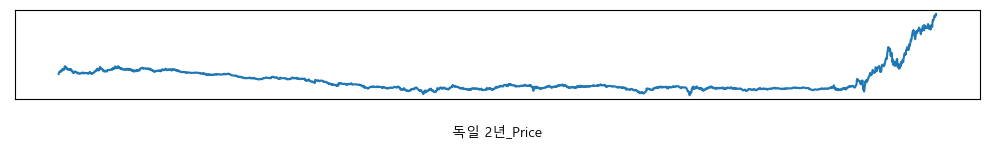

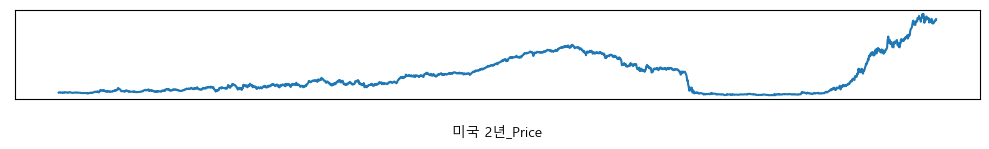

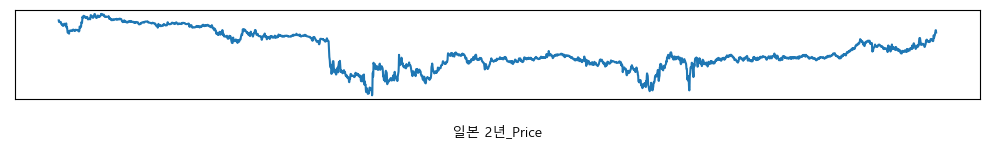

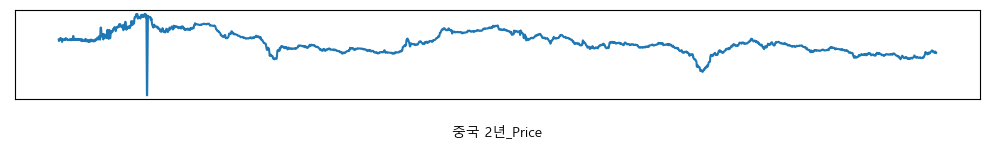

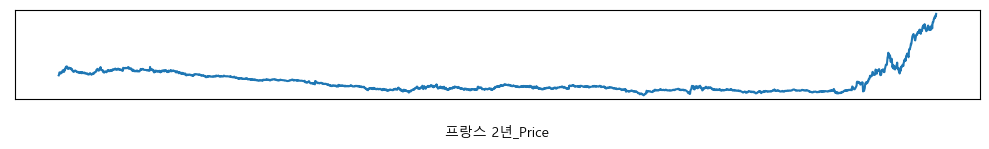

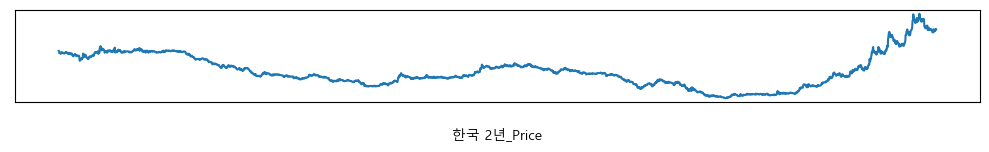

In [85]:
#국채금리
warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트

n = 1
for i in Treasury_rate:
    plt.figure(figsize=(10,8))
    plt.subplot(6,1,n)
    plt.plot(Total[[i]])
    plt.rc('axes', labelsize=10)
    plt.gca().axes.xaxis.set_ticks([])
    plt.gca().axes.yaxis.set_ticks([])
    plt.tight_layout(h_pad=3, w_pad=1)
    plt.xlabel(i, labelpad=15)
    n += 1

- 중국 2년 국채금리에서 급격히 낮아지는 부분을 확인 -> 1, 3년 국채금리와 비슷한 양상을 보여하지만 유일하게 다른 양상 -> 삭제 및 보간

In [88]:
Total["중국 2년_Price"].iloc[366:371] = np.nan # 2014-01-01 ~ 2014-01-05, 이상치와 이상치에 의해 보간된 값 모두 제거 후 재보간
Total["중국 2년_Price"] = Total["중국 2년_Price"].interpolate(method='cubic',axis=0)

Text(0.5, 0.5833333333333313, '중국 2년_Price')

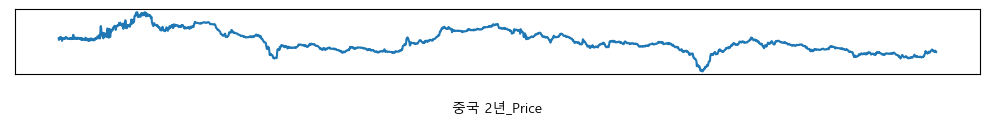

In [12]:
# 그래프 확인
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.figure(figsize=(10,1))
plt.plot(Total["중국 2년_Price"])
plt.rc('axes', labelsize=10)
plt.gca().axes.xaxis.set_ticks([])
plt.gca().axes.yaxis.set_ticks([])
plt.tight_layout(h_pad=3, w_pad=1)
plt.xlabel("중국 2년_Price", labelpad=15)

In [ ]:
Total.to_csv('C:\Users\whfhr\Desktop\신한 AI\사용data\Total.csv', index = False)